In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.io as pio
pio.renderers.deault = "png" # So that plots show on github

## Data Directories:

In [2]:
#--------Movie Lens Data directories-----------
MLens = "../Data/ml-latest-small/movies.csv"
MLensLinks = "../Data/ml-latest-small/links.csv"
MLensRatings = "../Data/ml-latest-small/ratings.csv"
MLensTags = "../Data/ml-latest-small/tags.csv"
#--------imdb Data directories-----------------
IMDB = "../Data/iMDB/IMDb movies.csv"
IMDBName = "../Data/iMDB/IMDb names.csv"
IMDBRatings = "../Data/iMDB/IMDb ratings.csv"
IMDBPrincipals = "../Data/iMDB/IMDb title_principals.csv"

In [3]:
imdbdf = pd.read_csv(IMDB,low_memory = False)

In [4]:
imdbdf.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

In [5]:
imdbdf_clean = imdbdf[['title','year', 'genre', 'duration', 'country', 'language','director', 'writer', 'production_company', 'actors', 'avg_vote']] #keep the wanted column

In [6]:
imdbdf_clean

title  year                      genre  \
0                          Miss Jerry  1894                    Romance   
1         The Story of the Kelly Gang  1906    Biography, Crime, Drama   
2                      Den sorte drøm  1911                      Drama   
3                           Cleopatra  1912             Drama, History   
4                           L'Inferno  1911  Adventure, Drama, Fantasy   
...                               ...   ...                        ...   
85850                         Le lion  2020                     Comedy   
85851  De Beentjes van Sint-Hildegard  2020              Comedy, Drama   
85852       Padmavyuhathile Abhimanyu  2019                      Drama   
85853               Sokagin Çocuklari  2019              Drama, Family   
85854      La vida sense la Sara Amat  2019                      Drama   

       duration           country       language  \
0            45               USA           None   
1            70         Australia           None   
2            53  Germany, Denmark            NaN   
3           100               USA        English   
4            68             Italy        Italian   
...         ...               ...            ...   
85850        95   France, Belgium         French   
85851       103       Netherlands  German, Dutch   
85852       130             India      Malayalam   
85853        98            Turkey        Turkish   
85854        74             Spain        Catalan   

                                  director  \
0                          Alexander Black   
1                             Charles Tait   
2                                Urban Gad   
3                       Charles L. Gaskill   
4      Francesco Bertolini, Adolfo Padovan   
...                                    ...   
85850               Ludovic Colbeau-Justin   
85851                      Johan Nijenhuis   
85852                      Vineesh Aaradya   
85853                    Ahmet Faik Akinci   
85854                            Laura Jou   

                                      writer             production_company  \
0                            Alexander Black     Alexander Black Photoplays   
1                               Charles Tait                 J. and N. Tait   
2      Urban Gad, Gebhard Schätzler-Perasini                       Fotorama   
3                           Victorien Sardou  Helen Gardner Picture Players   
4                            Dante Alighieri                    Milano Film   
...                                      ...                            ...   
85850  Alexandre Coquelle, Matthieu Le Naour              Monkey Pack Films   
85851           Radek Bajgar, Herman Finkers           Johan Nijenhuis & Co   
85852       Vineesh Aaradya, Vineesh Aaradya               RMCC Productions   
85853         Ahmet Faik Akinci, Kasim Uçkan                    Gizem Ajans   
85854                   Coral Cruz, Pep Puig  La Xarxa de Comunicació Local   

                                                  actors  avg_vote  
0      Blanche Bayliss, William Courtenay, Chauncey D...       5.9  
1      Elizabeth Tait, John Tait, Norman Campbell, Be...       6.1  
2      Asta Nielsen, Valdemar Psilander, Gunnar Helse...       5.8  
3      Helen Gardner, Pearl Sindelar, Miss Fielding, ...       5.2  
4      Salvatore Papa, Arturo Pirovano, Giuseppe de L...       7.0  
...                                                  ...       ...  
85850  Dany Boon, Philippe Katerine, Anne Serra, Samu...       5.3  
85851  Herman Finkers, Johanna ter Steege, Leonie ter...       7.7  
85852  Anoop Chandran, Indrans, Sona Nair, Simon Brit...       7.9  
85853  Ahmet Faik Akinci, Belma Mamati, Metin Keçeci,...       6.4  
85854  Maria Morera Colomer, Biel Rossell Pelfort, Is...       6.7  

[85855 rows x 11 columns]

Remove the row where the value for column 'year' is 'TV Movie 2019'

In [7]:
#imdbdf_clean[imdbdf_clean["year"] == 'TV Movie 2019']["year"].apply(lambda x: x[-4:])
imdbdf_clean = imdbdf_clean[imdbdf_clean.year != 'TV Movie 2019']
imdbdf_clean['year'] = imdbdf_clean['year'].astype('int')

In [8]:
imdbdf_clean.isna().sum() #find all the NaN values

title                    0
year                     0
genre                    0
duration                 0
country                 64
language               833
director                87
writer                1572
production_company    4455
actors                  69
avg_vote                 0
dtype: int64

In [9]:
imdbdf_clean = imdbdf_clean.dropna() #drop all the rows with NaN values
imdbdf_clean.isna().sum()

title                 0
year                  0
genre                 0
duration              0
country               0
language              0
director              0
writer                0
production_company    0
actors                0
avg_vote              0
dtype: int64

Separate the countries so we can analyze them separately.
This piece of code will be used later on (in the section "top countries creating movies").

In [10]:
countries = {} #create empty dictionary
list_countries = list(imdbdf_clean['country']) #set up a list of countries
for i in list_countries:
    i = list(i.split(',')) #split countries separated by commas
    if len(i) == 1: #if 1 country in countries.keys()
        if i in list(countries.keys()): #countries.keys() is the country name, countries.values() is the count of country name
            countries[i] +=1 #count
        else:
            countries[i[0]] = 0
    else:
        for j in i: #does the same but for len(i) != 1
            if j in list(countries.keys()):
                countries[j] += 1 #count
            else:
                countries[j] =1

Separate the genre so we can analyze them separately
This piece of code will be used later on.

In [11]:
genre = list(imdbdf_clean['genre'])
genre_list = [] #create an empty list

for i in genre:
    i = list(i.split(',')) #split words when comma
    for j in i:
        genre_list.append(j.replace(' ', '')) #replace extra space
        
genre_counter = Counter(genre_list) #We'll need it after

In [12]:
imdbdf_clean.describe()

year      duration      avg_vote
count  79437.000000  79437.000000  79437.000000
mean    1993.033309    100.080076      5.916458
std       24.348481     22.005550      1.215175
min     1894.000000     41.000000      1.000000
25%     1978.000000     88.000000      5.300000
50%     2002.000000     96.000000      6.100000
75%     2012.000000    108.000000      6.800000
max     2020.000000    808.000000      9.800000

**Distribution per year:**

In [13]:
#groupby year and count how many title we have each year
title = imdbdf_clean.groupby('year').agg({'title': ['count']})
title.columns = ['Title Count']
title = title.sort_values('Title Count', ascending = False)
title.head(5)

Title Count
year             
2017         2951
2018         2888
2016         2851
2015         2720
2014         2650

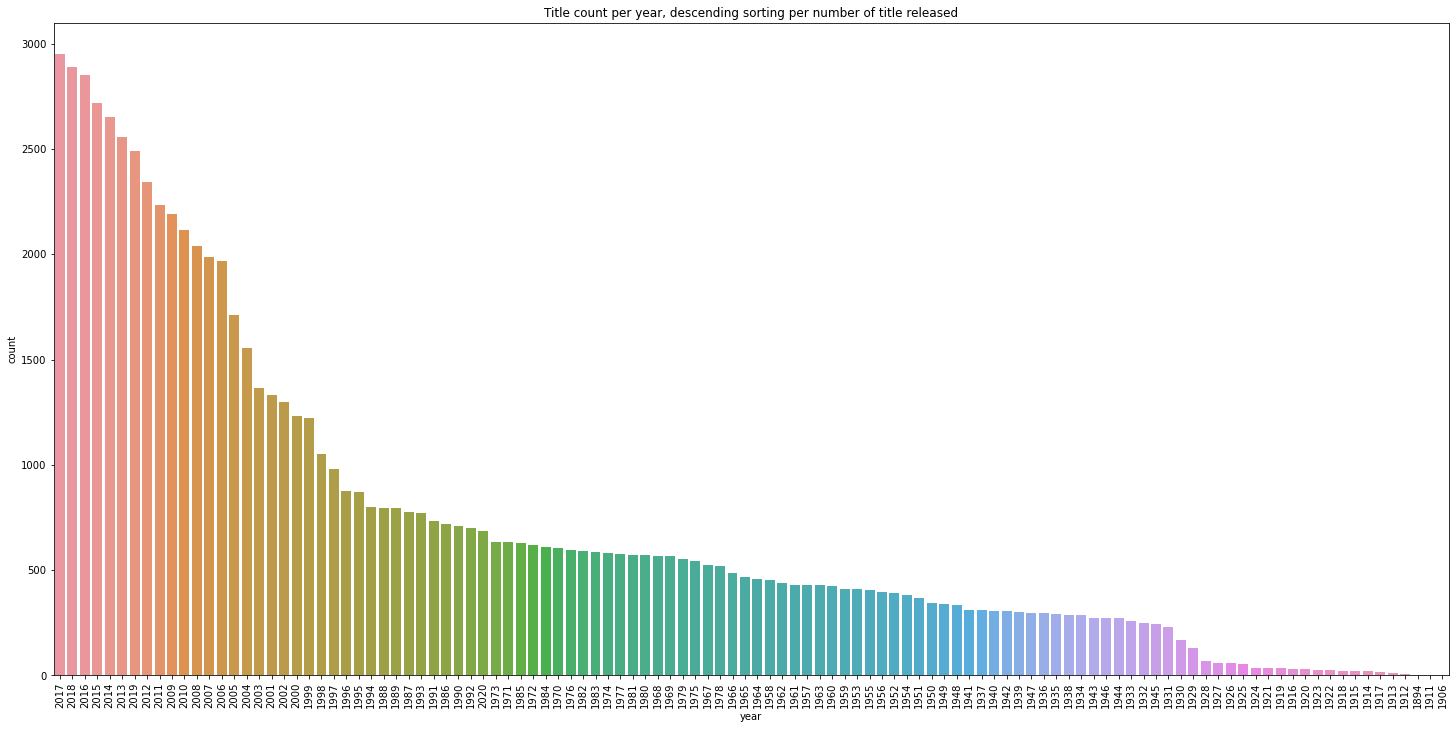

In [14]:
#visualize with a bar graph in descending title count order 
fig_dim = (25,12)
fig, ax = plt.subplots(figsize = fig_dim)
sns.countplot(x = 'year', data = imdbdf_clean, order = imdbdf_clean['year'].value_counts().index)
plt.title('Title count per year, descending sorting per number of title released')
plt.xticks(rotation=90)
plt.show()

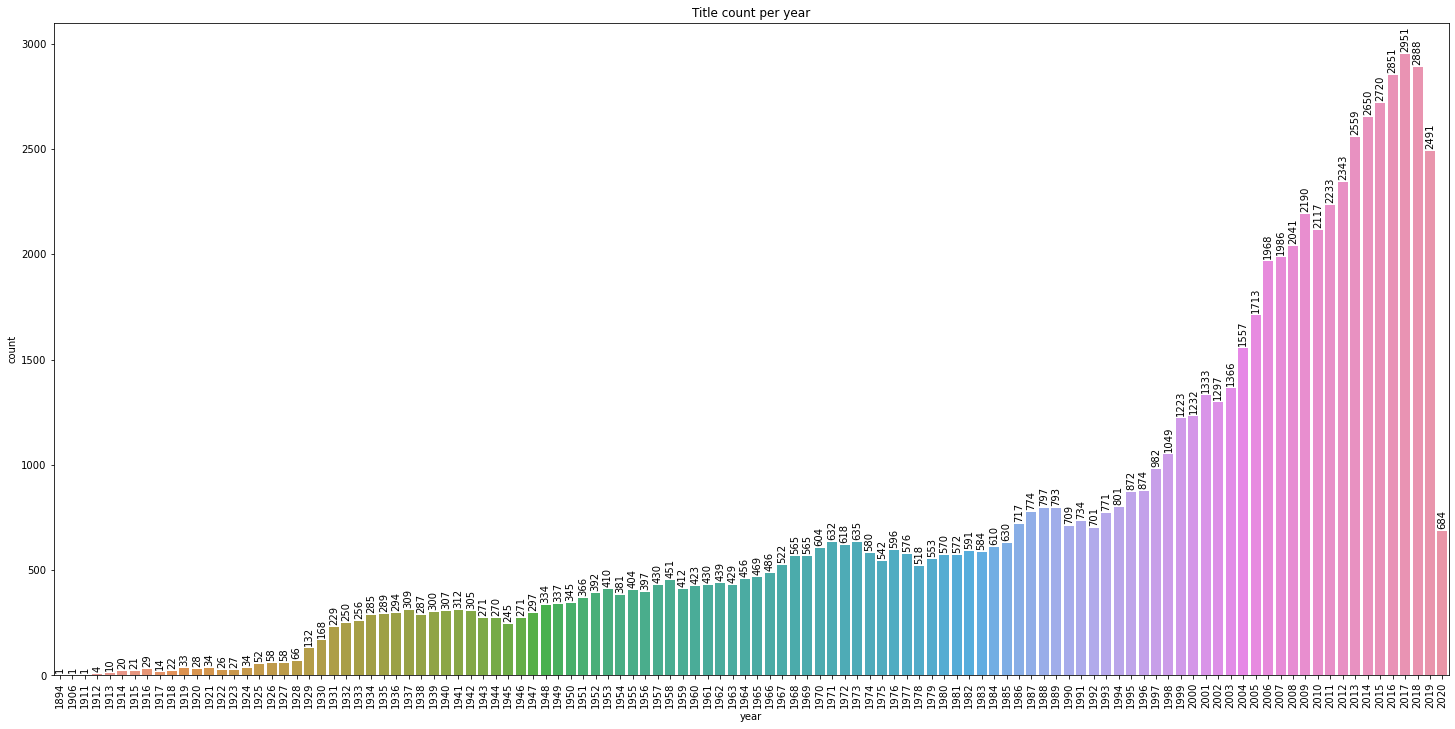

In [15]:
#visualize with a plot graph in ascending year order
fig_dim = (25,12)
fig, ax = plt.subplots(figsize = fig_dim)
ax = sns.countplot(x = 'year', data = imdbdf_clean)
plt.title('Title count per year')

#display the count on the bar graph
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x(), p.get_height() + 20), rotation=90)
    
plt.xticks(rotation=90)
plt.show()

Get the growth year to year (in %):

In [16]:
title

Title Count
year             
2017         2951
2018         2888
2016         2851
2015         2720
2014         2650
...           ...
1913           10
1912            4
1911            1
1906            1
1894            1

[112 rows x 1 columns]

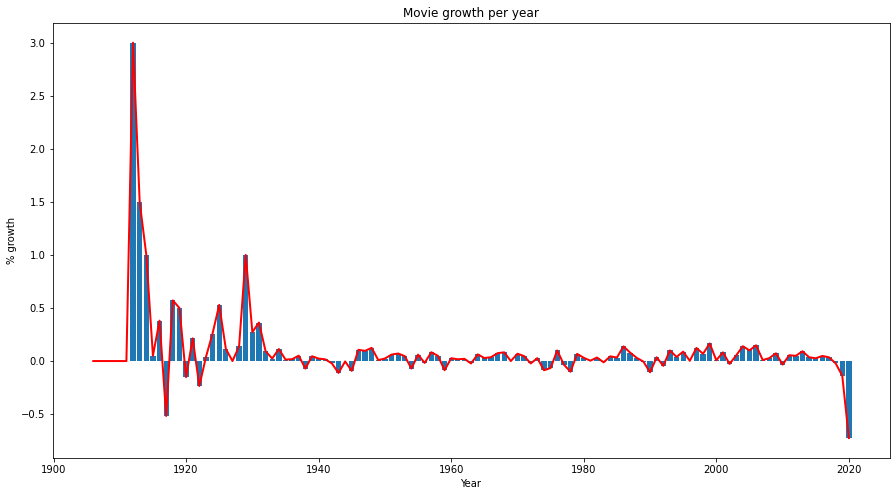

In [17]:
title = title.sort_index() #sort by year. The year is the index
growth = title.pct_change() #calculate the %growth year by year
growth.columns = ['% growth']
plt.figure(figsize = (15, 8))
x = growth['% growth']
y = growth.index
plt.bar(y, x)
plt.plot(y, x, color = 'red', linewidth = 2.0)
plt.title('Movie growth per year')
plt.xlabel('Year')
plt.ylabel('% growth')
plt.show()

**Get the top rated movies:**

Top 10 rated movie with the year and the country

All time best movies:

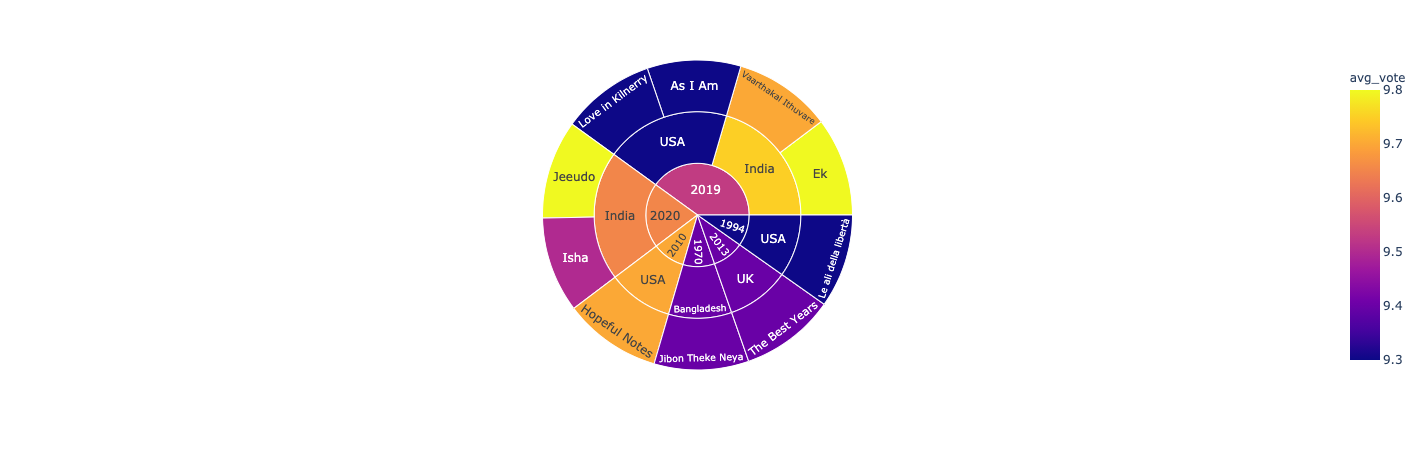

In [18]:
imdbdf_clean = imdbdf_clean.sort_values(by = 'avg_vote', ascending = False)
rating = imdbdf_clean[0:10] #get the 1st 10 values
fig = px.sunburst(rating, path = ['year', 'country', 'title'], values = 'avg_vote', color = 'avg_vote')
fig

Let's consider the best movies of this century:

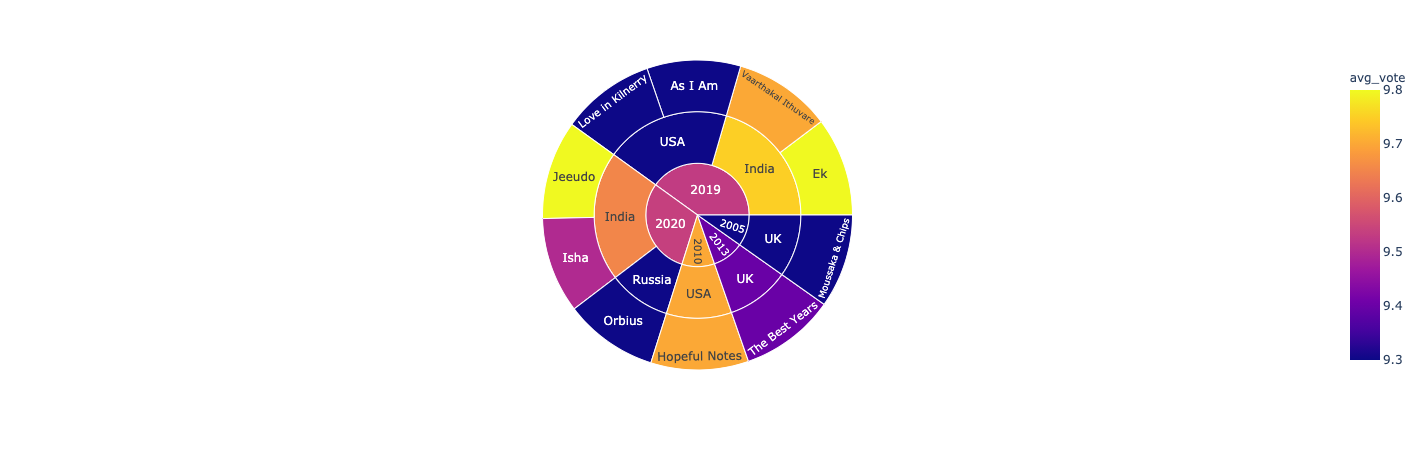

In [19]:
rating = imdbdf_clean[imdbdf_clean.year > 1999][0:10] #get the 1st 10 values
fig = px.sunburst(rating, path = ['year', 'country', 'title'], values = 'avg_vote', color = 'avg_vote')
fig

Let's see which year was the best year for movies production:

In [20]:
best = imdbdf_clean.groupby('year').agg({'avg_vote': ['mean']})
best.columns = ['Average rating']
best = best.sort_values('Average rating', ascending = False)
best.head()

Average rating
year                
1911        7.000000
1928        6.862121
1923        6.796296
1921        6.755882
1926        6.691379

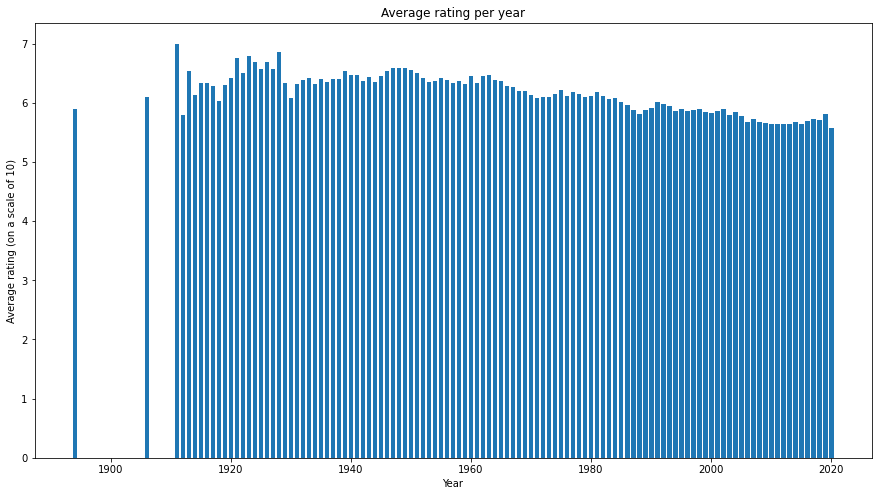

In [21]:
plt.figure(figsize = (15, 8))
x = best['Average rating'].round(decimals = 3)
y = best.index
plt.bar(y, x)
plt.title('Average rating per year')
plt.xlabel('Year')
plt.ylabel('Average rating (on a scale of 10)')
plt.show()

In [22]:
best = best[best.index >=2000]

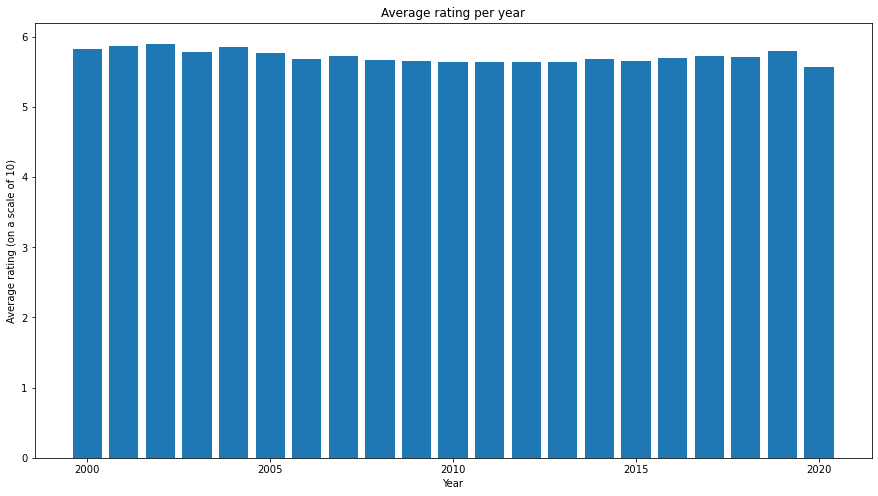

In [23]:
plt.figure(figsize = (15, 8))
x = best['Average rating'].round(decimals = 3)
y = best.index
plt.bar(y, x)
plt.title('Average rating per year')
plt.xlabel('Year')
plt.ylabel('Average rating (on a scale of 10)')
plt.show()

Top countries creating movies:

In [24]:
countries_fin = {} #create an empty dictionary
for country, no in countries.items(): 
    country = country.replace(' ', '') #remove the extra space create by the split(',')
    if country in list(countries_fin.keys()):
        countries_fin[country] += no
    else:
        countries_fin[country] = no

#sort the country according to their count
countries_fin = {k: v for k, v in sorted(countries_fin.items(), key = lambda item: item[1], reverse= True)}

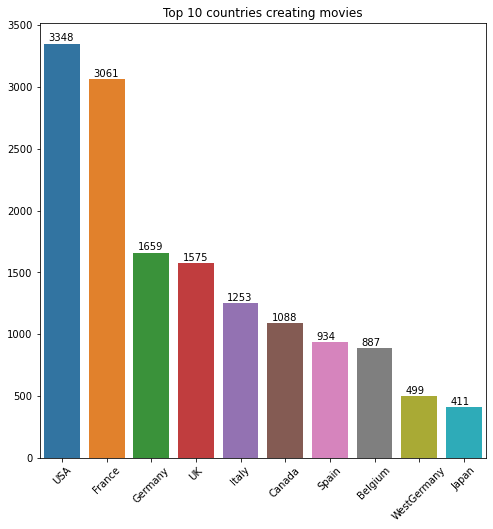

In [25]:
plt.figure(figsize = (8,8))
ax = sns.barplot(x = list(countries_fin.keys())[0:10], y = list(countries_fin.values())[0:10])
plt.title('Top 10 countries creating movies')
plt.xticks(rotation=45)
#display the count on the bar graph
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.1, p.get_height() + 20))
    
plt.show()

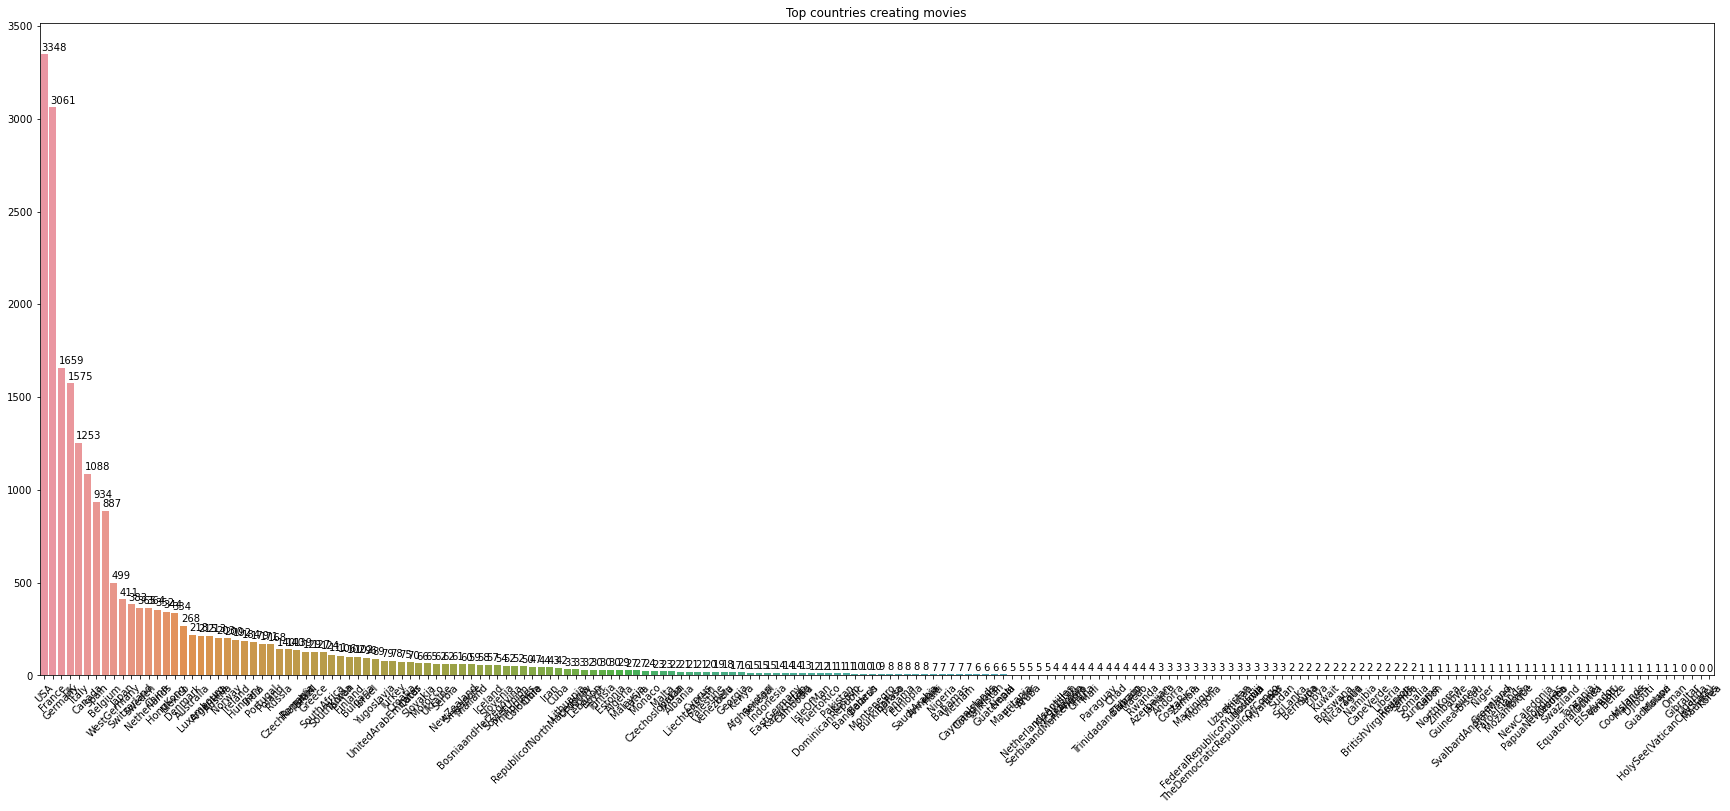

In [26]:
plt.figure(figsize = (30, 12))
ax = sns.barplot(x = list(countries_fin.keys()), y = list(countries_fin.values()))
plt.title('Top countries creating movies')
plt.xticks(rotation=45)
#display the count on the bar graph
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.1, p.get_height() + 20))
    
plt.show()

In [27]:
np.array(list(countries_fin.keys())).shape

(192,)

Let's see how each country conributes in the volume of all movies produced:

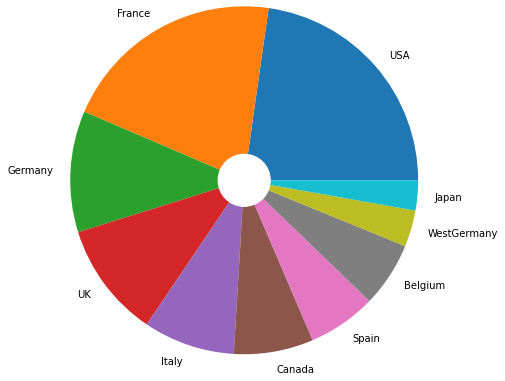

In [28]:
#create the dataframe
df_countries = pd.DataFrame(list(countries_fin.items()), columns = ['Country', 'Country count'])

#plot a pie chart of the distribution of each country per region
fig,ax = plt.subplots()
x = df_countries['Country count'][:10] #get the top 10 countries
labels = df_countries['Country'][:10] #get the top 10 countries
ax.pie(x, labels = labels, radius = 2)

#create a white circle at the center of the pie to create a donut chart
my_circle = plt.Circle( (0,0), 0.3, color = 'white')
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

**Genre:**

In [29]:
genres = {k: v for k, v in sorted(genre_counter.items(), key=lambda item: item[1], reverse= True)}
genres

{'Drama': 43799,
 'Comedy': 27276,
 'Romance': 13124,
 'Action': 12011,
 'Thriller': 10599,
 'Crime': 10473,
 'Horror': 8788,
 'Adventure': 7254,
 'Mystery': 4902,
 'Family': 3690,
 'Fantasy': 3552,
 'Sci-Fi': 3375,
 'Biography': 2302,
 'History': 2166,
 'War': 2109,
 'Animation': 1979,
 'Musical': 1900,
 'Music': 1612,
 'Western': 1545,
 'Sport': 1015,
 'Film-Noir': 661,
 'Reality-TV': 2,
 'Documentary': 1,
 'News': 1}

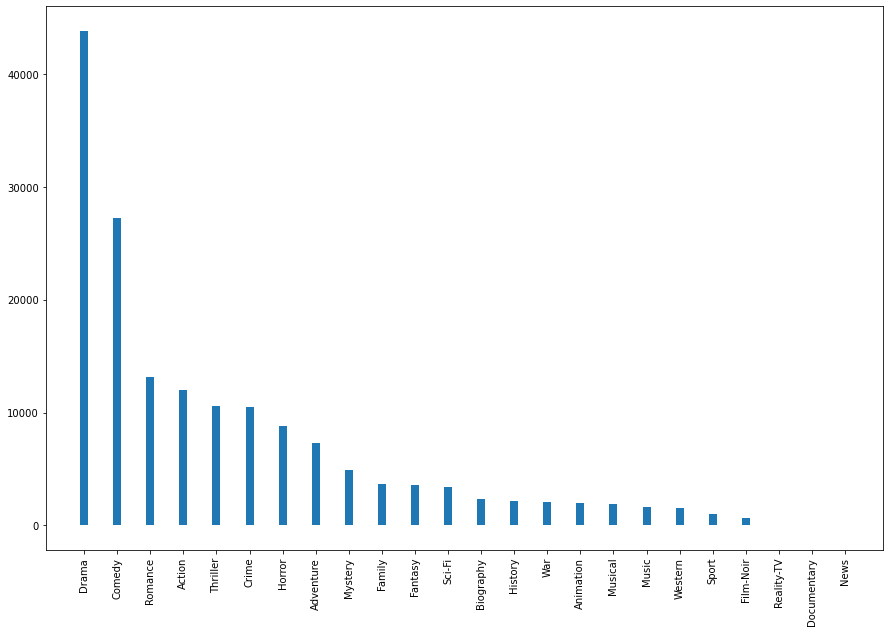

In [30]:
fig_dim = (15,10)
fig, ax = plt.subplots(figsize = fig_dim)
x = list(genres.keys())
y = list(genres.values())
ax.vlines(x, ymin = 0, ymax = y, linewidth = 8)
plt.xticks(rotation = 90)
plt.show()

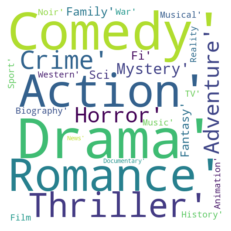

In [31]:
#create list of genre (unique genre)
text = list(genres.keys())

#create the wordcloud object
wordcloud = WordCloud(width = 500, height = 500, max_words = 100000, background_color = 'white').generate(str(text))

#Display the generated image
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.margins(x = 0, y = 0)
plt.show()

Exploring Plotly:

In [32]:
config = {'responsive': False}
genres_df = pd.DataFrame({"Genre":genres.keys(),"number_of_movies":genres.values()})

genres_bar = px.bar(genres_df[:10], 
                    x = 'Genre', 
                    y = 'number_of_movies', 
                    title = 'Top 10 Genres in terms of number of movies',
                    text = 'number_of_movies', 
                    labels = dict(genre = 'Genre', number_of_movies = 'Number of movies'),
                    color = 'Genre')
                    
genres_bar.show()

In [33]:
years_df = imdbdf_clean[['year','title', 'genre']].groupby(['year','genre']).count().reset_index().rename(columns={'title':'number_of_movies'})
years_df = years_df.sort_values(by=['number_of_movies'], ascending=False)
years_df = years_df[years_df['year'] >= 2000]#Movies of this century 
years_df = years_df[years_df['number_of_movies'] >= 100]#years where the number of movies is over 100

In [34]:
detailed_genres_bar = px.bar(years_df, 
                             x ='year', 
                             y = 'number_of_movies', 
                             color = 'genre', 
                             title='Movies produced in the 21st century classified by genres', 
                             text = 'number_of_movies',
                             labels = dict(year = 'Year', number_of_movies = 'Number of movies')
                             )
detailed_genres_bar.show()

**Producction Companies:**

In [37]:
production_companies_df = imdbdf_clean[['production_company','title']].groupby(['production_company']).count().reset_index().rename(columns={'title':'number_of_movies'})
production_companies_df = production_companies_df.sort_values(by='number_of_movies', ascending=False)
production_companies_df = production_companies_df[:10]
production_companies_df

production_company  number_of_movies
20433              Metro-Goldwyn-Mayer (MGM)              1270
30370                           Warner Bros.              1149
8105                       Columbia Pictures               913
22958                     Paramount Pictures               890
29414                  Twentieth Century Fox               864
29680                     Universal Pictures               730
24417                     RKO Radio Pictures               535
21021                                Mosfilm               277
29676  Universal International Pictures (UI)               272
6344                                  Canal+               229

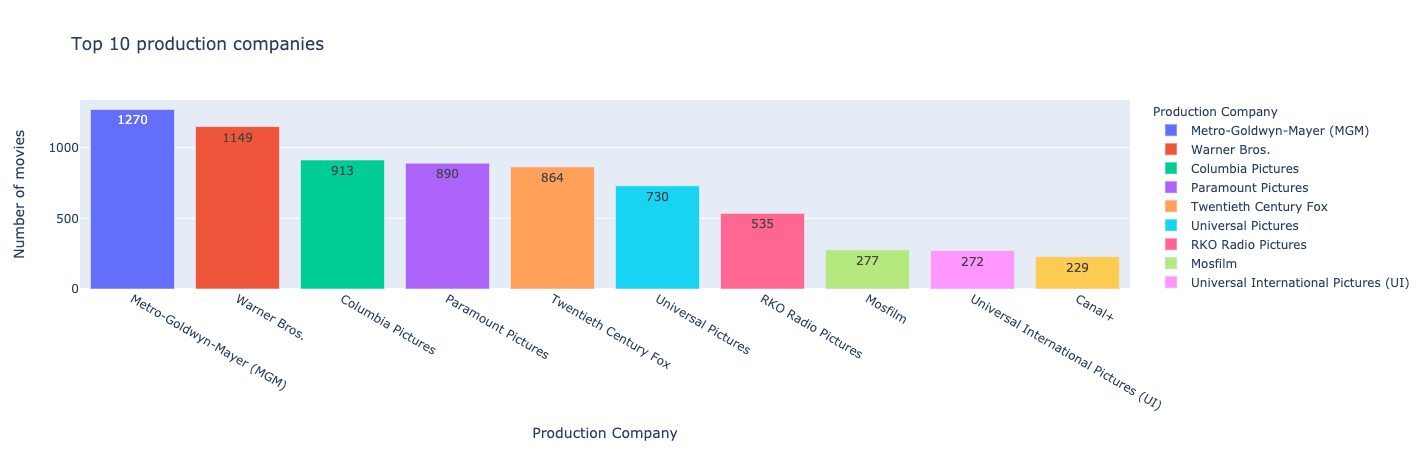

In [38]:
detailed_genres_bar = px.bar(production_companies_df, 
                             x ='production_company', 
                             y = 'number_of_movies', 
                             color = 'production_company', 
                             title='Top 10 production companies', 
                             text = 'number_of_movies',
                             labels = dict(production_company = 'Production Company', number_of_movies = 'Number of movies')
                             )
detailed_genres_bar.show()

If we choose only this century:

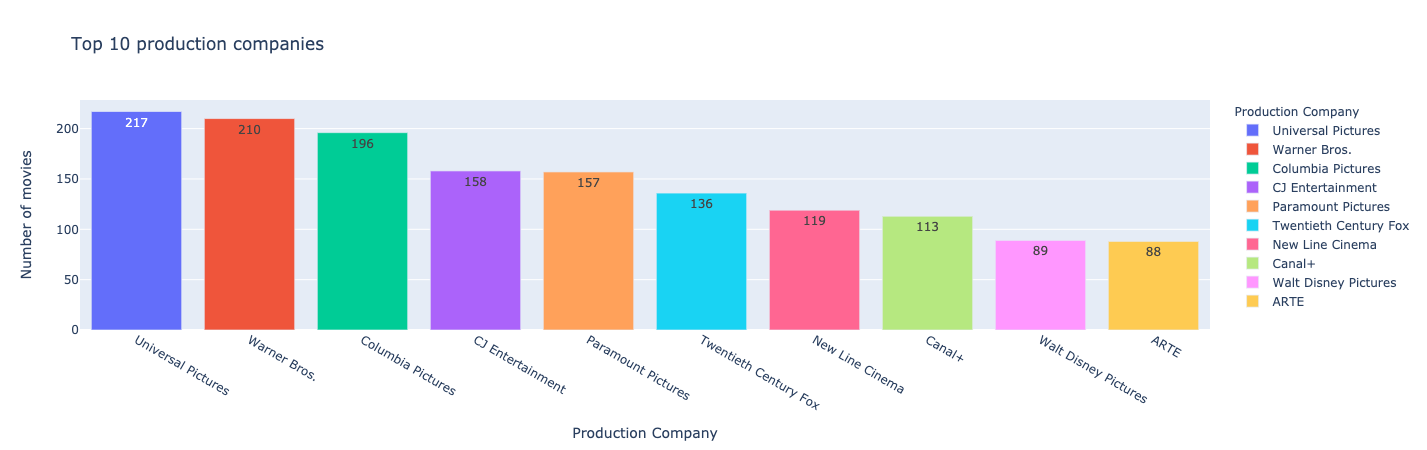

In [39]:
production_companies_df = imdbdf_clean[imdbdf_clean.year > 1999][['production_company','title']].groupby(['production_company']).count().reset_index().rename(columns={'title':'number_of_movies'})
production_companies_df = production_companies_df.sort_values(by='number_of_movies', ascending=False)
production_companies_df = production_companies_df.iloc[:10]
detailed_genres_bar = px.bar(production_companies_df, 
                             x ='production_company', 
                             y = 'number_of_movies', 
                             color = 'production_company', 
                             title='Top 10 production companies', 
                             text = 'number_of_movies',
                             labels = dict(production_company = 'Production Company', number_of_movies = 'Number of movies')
                             )
detailed_genres_bar.show()

----

## Save Cleaned IMDb data:

In [40]:
imdbdf = pd.read_csv(IMDB,low_memory = False)

In [41]:
imdbdf_clean = imdbdf[['title','year', 'genre', 'duration', 'country', 'language','director', 'writer', 'production_company', 'actors', 'avg_vote']] #keep the wanted column

In [42]:
imdbdf_clean

title  year                      genre  \
0                          Miss Jerry  1894                    Romance   
1         The Story of the Kelly Gang  1906    Biography, Crime, Drama   
2                      Den sorte drøm  1911                      Drama   
3                           Cleopatra  1912             Drama, History   
4                           L'Inferno  1911  Adventure, Drama, Fantasy   
...                               ...   ...                        ...   
85850                         Le lion  2020                     Comedy   
85851  De Beentjes van Sint-Hildegard  2020              Comedy, Drama   
85852       Padmavyuhathile Abhimanyu  2019                      Drama   
85853               Sokagin Çocuklari  2019              Drama, Family   
85854      La vida sense la Sara Amat  2019                      Drama   

       duration           country       language  \
0            45               USA           None   
1            70         Australia           None   
2            53  Germany, Denmark            NaN   
3           100               USA        English   
4            68             Italy        Italian   
...         ...               ...            ...   
85850        95   France, Belgium         French   
85851       103       Netherlands  German, Dutch   
85852       130             India      Malayalam   
85853        98            Turkey        Turkish   
85854        74             Spain        Catalan   

                                  director  \
0                          Alexander Black   
1                             Charles Tait   
2                                Urban Gad   
3                       Charles L. Gaskill   
4      Francesco Bertolini, Adolfo Padovan   
...                                    ...   
85850               Ludovic Colbeau-Justin   
85851                      Johan Nijenhuis   
85852                      Vineesh Aaradya   
85853                    Ahmet Faik Akinci   
85854                            Laura Jou   

                                      writer             production_company  \
0                            Alexander Black     Alexander Black Photoplays   
1                               Charles Tait                 J. and N. Tait   
2      Urban Gad, Gebhard Schätzler-Perasini                       Fotorama   
3                           Victorien Sardou  Helen Gardner Picture Players   
4                            Dante Alighieri                    Milano Film   
...                                      ...                            ...   
85850  Alexandre Coquelle, Matthieu Le Naour              Monkey Pack Films   
85851           Radek Bajgar, Herman Finkers           Johan Nijenhuis & Co   
85852       Vineesh Aaradya, Vineesh Aaradya               RMCC Productions   
85853         Ahmet Faik Akinci, Kasim Uçkan                    Gizem Ajans   
85854                   Coral Cruz, Pep Puig  La Xarxa de Comunicació Local   

                                                  actors  avg_vote  
0      Blanche Bayliss, William Courtenay, Chauncey D...       5.9  
1      Elizabeth Tait, John Tait, Norman Campbell, Be...       6.1  
2      Asta Nielsen, Valdemar Psilander, Gunnar Helse...       5.8  
3      Helen Gardner, Pearl Sindelar, Miss Fielding, ...       5.2  
4      Salvatore Papa, Arturo Pirovano, Giuseppe de L...       7.0  
...                                                  ...       ...  
85850  Dany Boon, Philippe Katerine, Anne Serra, Samu...       5.3  
85851  Herman Finkers, Johanna ter Steege, Leonie ter...       7.7  
85852  Anoop Chandran, Indrans, Sona Nair, Simon Brit...       7.9  
85853  Ahmet Faik Akinci, Belma Mamati, Metin Keçeci,...       6.4  
85854  Maria Morera Colomer, Biel Rossell Pelfort, Is...       6.7  

[85855 rows x 11 columns]

**Cleaning:**

In [43]:
imdbdf_clean = imdbdf_clean[imdbdf_clean.year != 'TV Movie 2019']
imdbdf_clean['year'] = imdbdf_clean['year'].astype('int')

In [44]:
imdbdf_clean = imdbdf_clean.dropna() #drop all the rows with NaN values
imdbdf_clean.isna().sum()

title                 0
year                  0
genre                 0
duration              0
country               0
language              0
director              0
writer                0
production_company    0
actors                0
avg_vote              0
dtype: int64

In [45]:
#Write the cleaned data
imdbdf_clean.to_csv("../../Data/IMDb_clean.csv",index=False)